This notebook plots leading and subleading leptonsJets' BDT score/passes in control/signal region in 2D.

In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot
from awkward import JaggedArray

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
datasets_=json.load(open('../Samples/backgrounds_nonempty.json'))
scales_=json.load(open('../Samples/backgrounds_scale.json'))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        files = datasets_[group][tag]
        datasets[tag] = {'files': files, 'treename': 'ffNtuplizer/ffNtuple'}

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 60.432*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])

## score

In [3]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'background datasets')
        mva0_axis    = hist.Bin('mva0', 'leading BDT value', 50, -10, 10)
        mva1_axis    = hist.Bin('mva1', 'subleading BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'mvaCR': hist.Hist("#counts/0.4", dataset_axis, mva0_axis, mva1_axis),
            'mvaSR': hist.Hist("#counts/0.4", dataset_axis, mva0_axis, mva1_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            mva=df['pfjet_mva'],
        )
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        if not dileptonjets.size: return output
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:,1], 1)]
        controlregion = np.abs(leadlj.p4.delta_phi(subllj.p4))<2.5
        signalregion = ~controlregion
        
        output['mvaCR'].fill(dataset=dataset,
                             mva0=leadlj[controlregion].mva.flatten(),
                             mva1=subllj[controlregion].mva.flatten(),
                             weight=wgt[controlregion.flatten()]
                            )
        output['mvaSR'].fill(dataset=dataset,
                             mva0=leadlj[signalregion].mva.flatten(),
                             mva1=subllj[signalregion].mva.flatten(),
                             weight=wgt[signalregion.flatten()]
                            )
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [08:25<00:00, 10.89items/s]


## control region

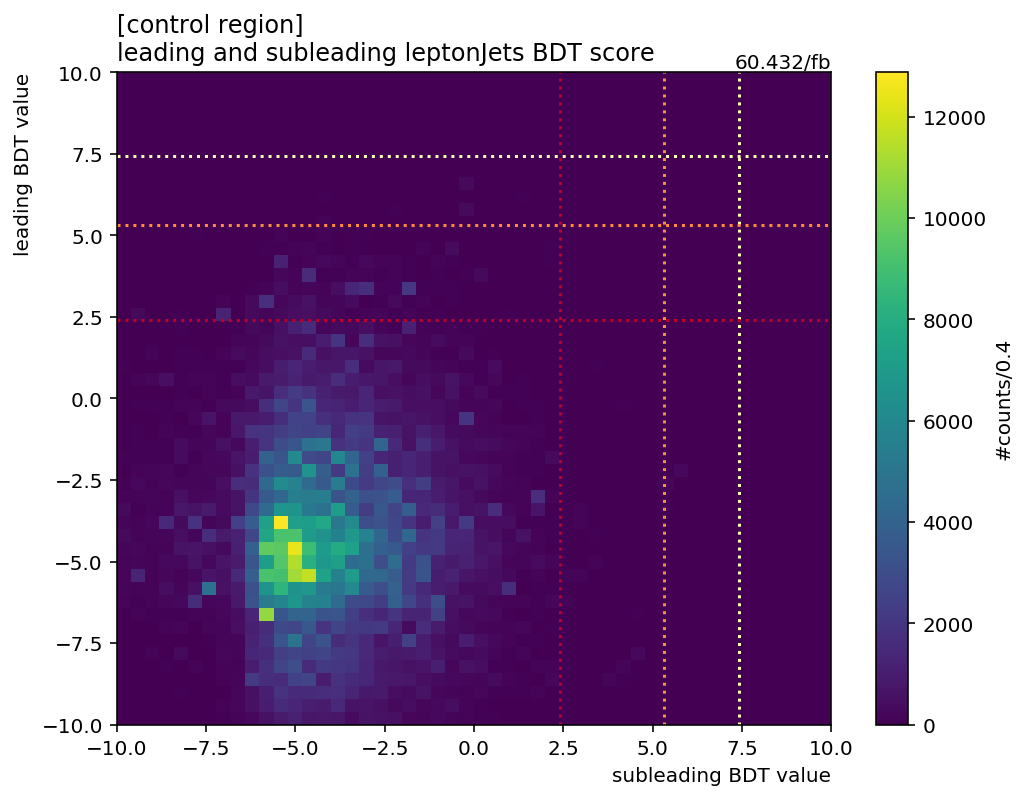

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot2d(output['mvaCR_cat'].sum('cat'), xaxis='mva1', ax=ax)
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region]\nleading and subleading leptonJets BDT score', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

# add lines
looseval = 2.3958024978637695
mediumval = 5.316260814666748
tightval = 7.421047687530518
ax.vlines([looseval, mediumval, tightval], -10, 10, colors=['#bd0026', '#fd8d3c', '#ffffb2'], ls=':')
ax.hlines([looseval, mediumval, tightval], -10, 10, colors=['#bd0026', '#fd8d3c', '#ffffb2'], ls=':');

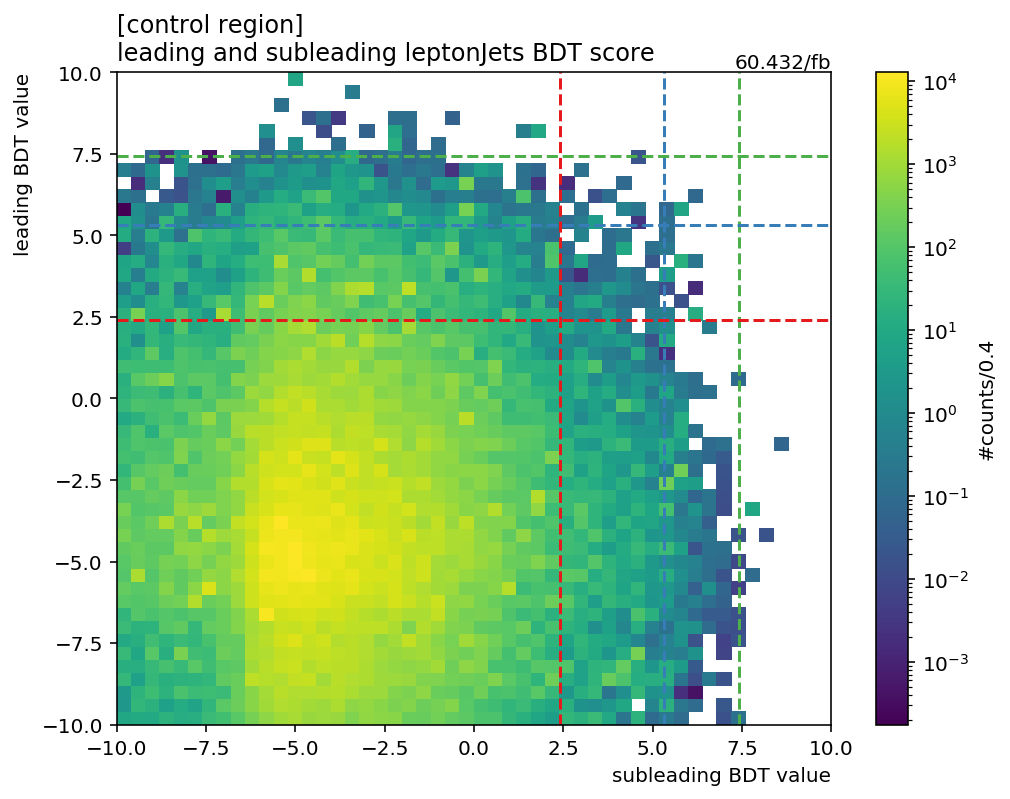

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot2d(output['mvaCR_cat'].sum('cat'), xaxis='mva1', ax=ax, patch_opts=dict(norm=LogNorm()))
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region]\nleading and subleading leptonJets BDT score', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

# add lines
looseval = 2.3958024978637695
mediumval = 5.316260814666748
tightval = 7.421047687530518
ax.vlines([looseval, mediumval, tightval], -10, 10, colors=['#e41a1c', '#377eb8', '#4daf4a'], ls='--')
ax.hlines([looseval, mediumval, tightval], -10, 10, colors=['#e41a1c', '#377eb8', '#4daf4a'], ls='--');

### signal region

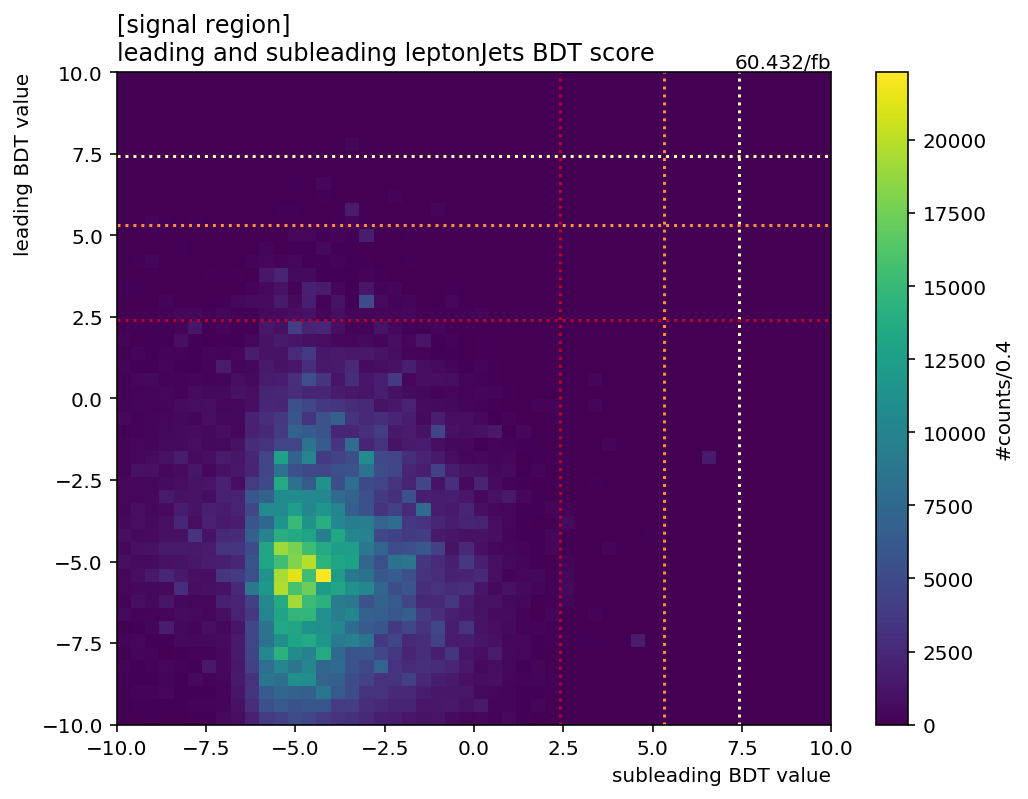

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot2d(output['mvaSR_cat'].sum('cat'), xaxis='mva1', ax=ax)
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[signal region]\nleading and subleading leptonJets BDT score', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

# add lines
looseval = 2.3958024978637695
mediumval = 5.316260814666748
tightval = 7.421047687530518
ax.vlines([looseval, mediumval, tightval], -10, 10, colors=['#bd0026', '#fd8d3c', '#ffffb2'], ls=':')
ax.hlines([looseval, mediumval, tightval], -10, 10, colors=['#bd0026', '#fd8d3c', '#ffffb2'], ls=':');

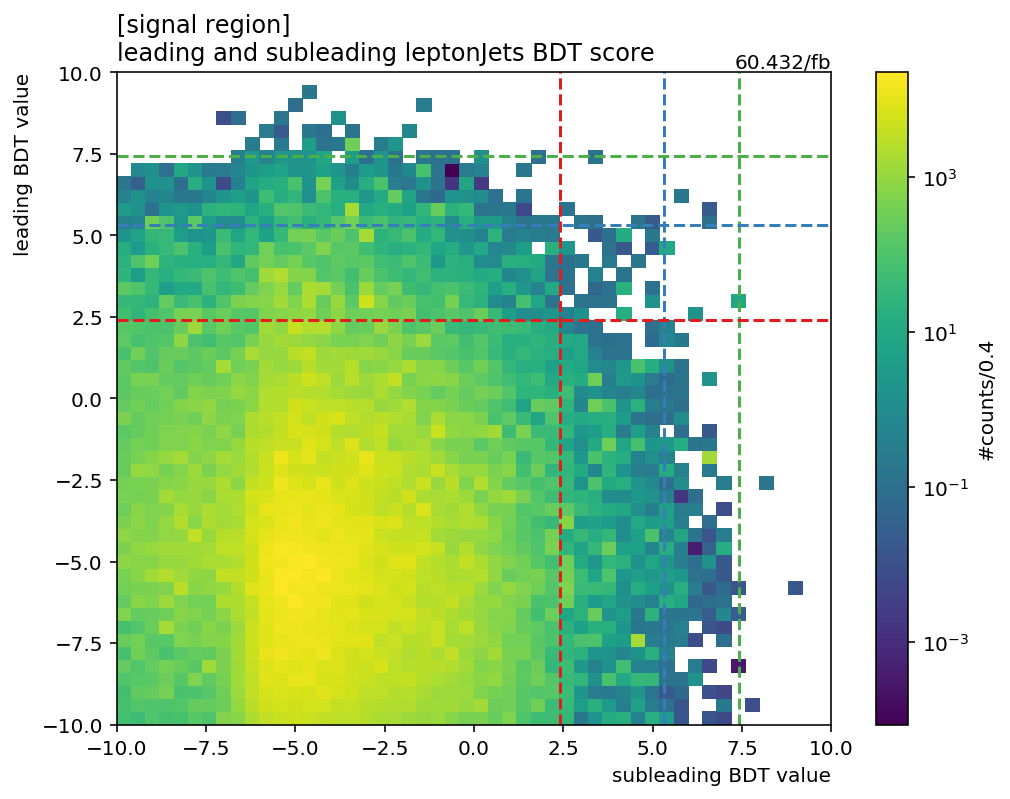

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot2d(output['mvaSR_cat'].sum('cat'), xaxis='mva1', ax=ax, patch_opts=dict(norm=LogNorm()))
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[signal region]\nleading and subleading leptonJets BDT score', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

# add lines
looseval = 2.3958024978637695
mediumval = 5.316260814666748
tightval = 7.421047687530518
ax.vlines([looseval, mediumval, tightval], -10, 10, colors=['#e41a1c', '#377eb8', '#4daf4a'], ls='--')
ax.hlines([looseval, mediumval, tightval], -10, 10, colors=['#e41a1c', '#377eb8', '#4daf4a'], ls='--');

## Per category

In [7]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'background datasets')
        mva0_axis    = hist.Bin('mva0', 'leading BDT value', 4, 0, 4)
        mva1_axis    = hist.Bin('mva1', 'subleading BDT value', 4, 0, 4)
        
        self._accumulator = processor.dict_accumulator({
            'mvaCR': hist.Hist("#counts/bin", dataset_axis, mva0_axis, mva1_axis),
            'mvaSR': hist.Hist("#counts/bin", dataset_axis, mva0_axis, mva1_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)

        wnlo = np.ones_like(df.size)
        if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
            genparticles = JaggedCandidateArray.candidatesfromcounts(
                df['gen_p4'],
                px=df['gen_p4.fCoordinates.fX'],
                py=df['gen_p4.fCoordinates.fY'],
                pz=df['gen_p4.fCoordinates.fZ'],
                energy=df['gen_p4.fCoordinates.fT'],
                pid=df['gen_pid'],
            )
            gentops = genparticles[np.abs(genparticles.pid)==6]
            genws = genparticles[np.abs(genparticles.pid)==24]
            genzs = genparticles[np.abs(genparticles.pid)==23]

            if 'TTJets' in dataset:
                wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
            elif 'WJets' in dataset:
                wnlo = self.nlo_w(genws[0].p4.pt.sum())
            elif 'DYJets' in dataset:
                wnlo = self.nlo_z(genzs[0].p4.pt.sum())
        wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']
        rawmva=df['pfjet_mva']
        _neutral = nef>0.999
        _tracked = ~_neutral
        mva_neutral = (rawmva*_neutral > 2.010711908340454).astype(int) +\
                      (rawmva*_neutral > 5.317723751068115).astype(int) +\
                      (rawmva*_neutral > 6.909248352050781).astype(int)
        mva_tracked = (rawmva*_tracked > 2.3958024978637695).astype(int) +\
                      (rawmva*_tracked > 5.316260814666748).astype(int) +\
                      (rawmva*_tracked > 7.421047687530518).astype(int)
        mva = mva_neutral+mva_tracked
            
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            mva=mva
        )
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        if not dileptonjets.size: return output
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:,1], 1)]
        controlregion = np.abs(leadlj.p4.delta_phi(subllj.p4))<2.5
        signalregion = ~controlregion
        
        output['mvaCR'].fill(dataset=dataset,
                             mva0=leadlj[controlregion].mva.flatten(),
                             mva1=subllj[controlregion].mva.flatten(),
                             weight=wgt[controlregion.flatten()]
                            )
        output['mvaSR'].fill(dataset=dataset,
                             mva0=leadlj[signalregion].mva.flatten(),
                             mva1=subllj[signalregion].mva.flatten(),
                             weight=wgt[signalregion.flatten()]
                            )
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)
        # scale
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
        # cat grouping
            accumulator[k+'_cat'] = accumulator[k].group(hist.Cat("cat", "datasets"), "dataset", mapping)
        return accumulator

In [8]:
output = processor.run_uproot_job(datasets,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 4302/4302 [08:08<00:00,  8.80items/s] 


### control region

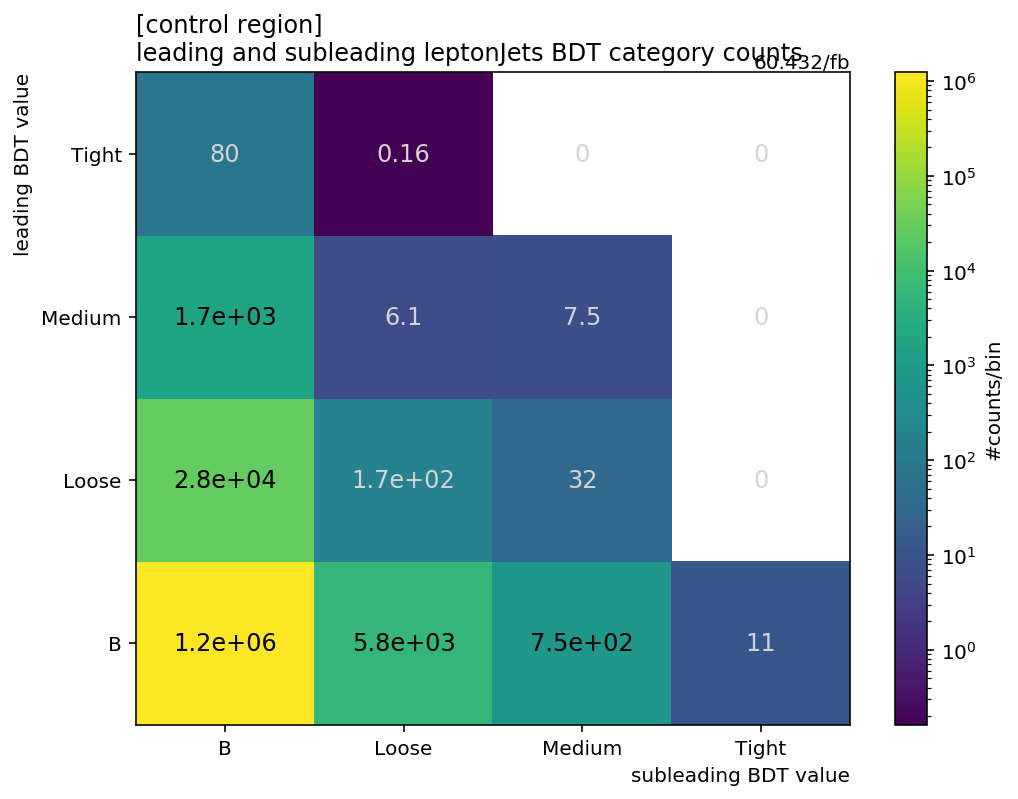

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot2d(output['mvaCR_cat'].sum('cat'), xaxis='mva1', ax=ax, patch_opts=dict(norm=LogNorm()), text_opts={'format': '%.2g', 'fontsize': 'large'})
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[control region]\nleading and subleading leptonJets BDT category counts', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

tickpos = [0.5, 1.5, 2.5, 3.5]
ticklbl = ['B', 'Loose', 'Medium', 'Tight']

ax.set_xticks(tickpos)
ax.set_xticklabels(ticklbl)
ax.set_yticks(tickpos)
ax.set_yticklabels(ticklbl);

### signal region

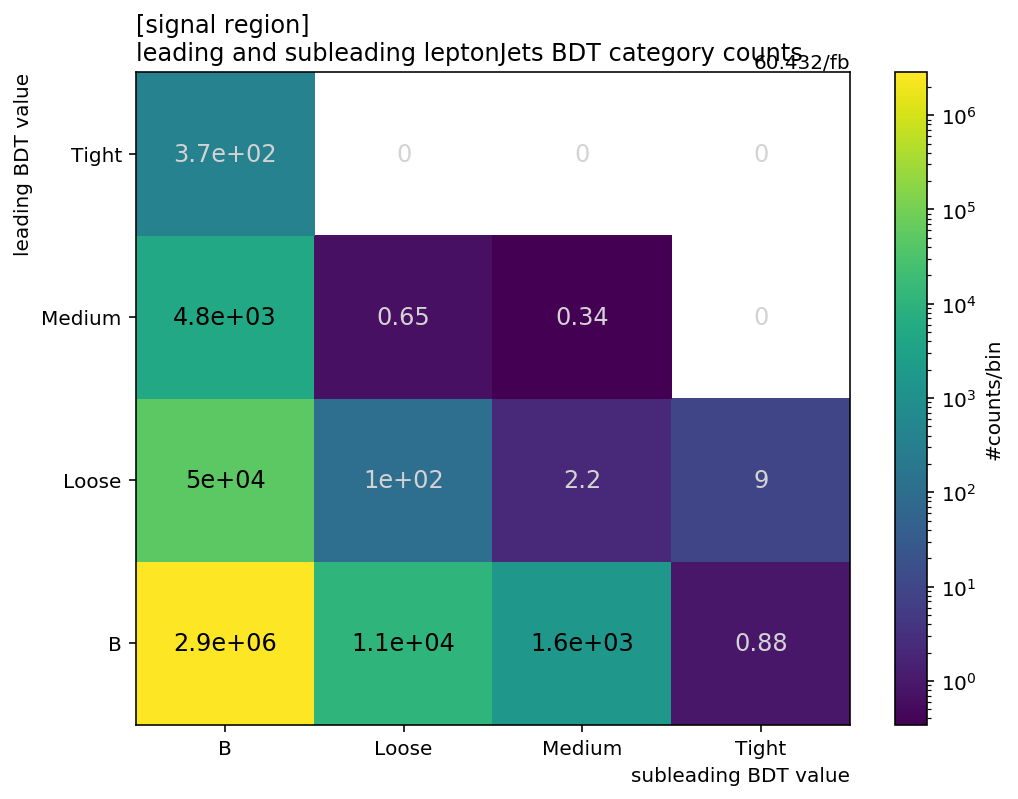

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
hist.plot2d(output['mvaSR_cat'].sum('cat'), xaxis='mva1', ax=ax, patch_opts=dict(norm=LogNorm()), text_opts={'format': '%.2g', 'fontsize': 'large'})
ax.text(1,1,'60.432/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[signal region]\nleading and subleading leptonJets BDT category counts', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

tickpos = [0.5, 1.5, 2.5, 3.5]
ticklbl = ['B', 'Loose', 'Medium', 'Tight']

ax.set_xticks(tickpos)
ax.set_xticklabels(ticklbl)
ax.set_yticks(tickpos)
ax.set_yticklabels(ticklbl);